In [1]:
! pip3 install scikit-learn

     |████████████████████████████████| 31.2 MB 69 kB/s  eta 0:00:011
     |████████████████████████████████| 297 kB 6.5 MB/s eta 0:00:01


In [107]:
import csv
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
def import_csv(filename):
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        keys = reader.__iter__().__next__()
        dict_ = {key : [v] for key, v in zip(keys, reader.__iter__().__next__()) }
        for row in reader:
            for k, v in zip(dict_, row):
                dict_[k].append(v)
        return dict_

data1 = import_csv('archive/student-mat.csv')
data2 = import_csv('archive/student-por.csv')
encs = dict()
for key in data1:
    data1[key] = np.array( data1[key] + data2[key])
    enc = OrdinalEncoder()
    encs[key] = enc
    data1[key] = enc.fit_transform(data1[key].reshape((-1,1)))
    data1[key] = data1[key].reshape((-1))
data = data1
dec_dalc = encs['Dalc'].inverse_transform(data['Dalc'].reshape((-1,1))).flatten().astype(np.int32)
dec_walc = encs['Walc'].inverse_transform(data['Walc'].reshape((-1,1))).flatten().astype(np.int32)

data['avgalc'] = (dec_dalc + dec_walc)/2.0

target = data['avgalc']

## Соотношение классов

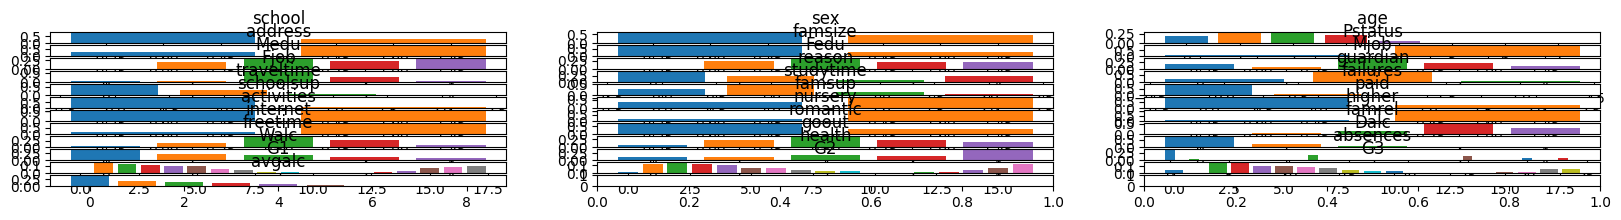

In [108]:
import matplotlib.pyplot as plt 

class_values = dict()
for key in data:
    amount = []
    for u in np.unique(data[key]):
        amount.append(data[key][data[key] == u].shape[0]/data[key].shape[0])
    class_values[key] = amount


def draw_chart(ax, values, name):
    for i, val in enumerate(values):  
        ax.bar(i, val)
    ax.set_title(name)

fig, axs = plt.subplots(class_values.keys().__len__()// 3 + 1, 3)
for ax, key in zip(axs.flatten(), class_values):
    draw_chart(ax, class_values[key], key)
plt.show()


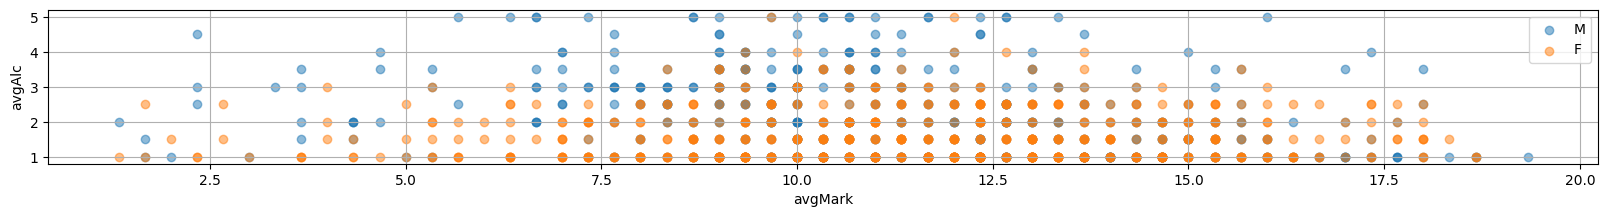

In [147]:
plt.rcParams['figure.figsize'] = [20, 2]
m_feature = encs['sex'].transform([['M']])[0,0]
f_feature = encs['sex'].transform([['F']])[0,0]
targetM = target[data['sex'] == m_feature]
targetF = target[data['sex'] == f_feature]
def decode(d, name):
    return encs[name].inverse_transform(d.reshape((-1,1))).flatten().astype(np.float32)
avgMarkM = (decode(data['G1'], 'G1') + decode(data['G2'], 'G2') + decode(data['G3'], 'G3'))[data['sex'] == m_feature]/3.0
avgMarkF = (decode(data['G1'], 'G1') + decode(data['G2'], 'G2') + decode(data['G3'], 'G3'))[data['sex'] == f_feature]/3.0

plt.scatter(avgMarkM, targetM, label = 'M', alpha=0.5, )
plt.scatter(avgMarkF, targetF, label = 'F', alpha=0.5)
plt.xlabel('avgMark')
plt.ylabel('avgAlc')
plt.grid()


data['avgmark'] = (decode(data['G1'], 'G1') + decode(data['G2'], 'G2') + decode(data['G3'], 'G3'))/3.0

plt.legend()
plt.show()


Можно сделать несколько выводов:
1. Женщины пьют меньше мужчин
2. походит на нормальное распределение
3. Ближе к отличным оценкам явно наблюдается тренд на снижение

Сопоставим данные между школами

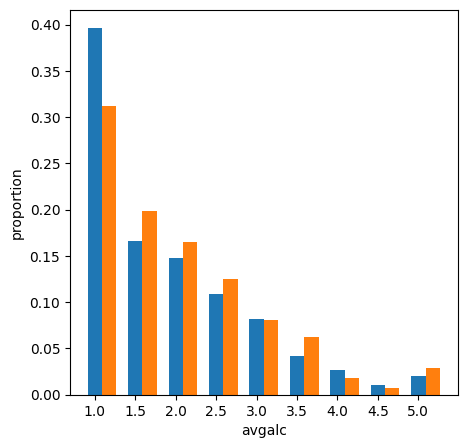

In [138]:
plt.rcParams['figure.figsize'] = [5, 5]
targets_by_school = [target[data['school'] == key] for key in np.unique(data['school'])]
targets_by_school_c= [{ u :  st[st==u].shape[0] / st.shape[0] for u in np.unique(target) } for st in targets_by_school]
fig, ax = plt.subplots()

x = np.linspace(0, len(np.unique(target)), len(np.unique(target)))
labels = targets_by_school_c[0].keys()
width = 0.4
ax.set_xticks(x.copy(), labels)
for sc in targets_by_school_c:
    rect = ax.bar(x, sc.values(), [width]*len(sc))
    x+=width
plt.xlabel('avgalc')
plt.ylabel('proportion')
plt.show()

Наблюдается, что в одной из школ степень минимального потребления алкоголя сильно превосходит другую, по другим степеням вторая школа опережает первую. Из чего можно сделать вывод о корреляции фактора школы с целевой переменной.

Проверим корреляцию между avgmark и absences

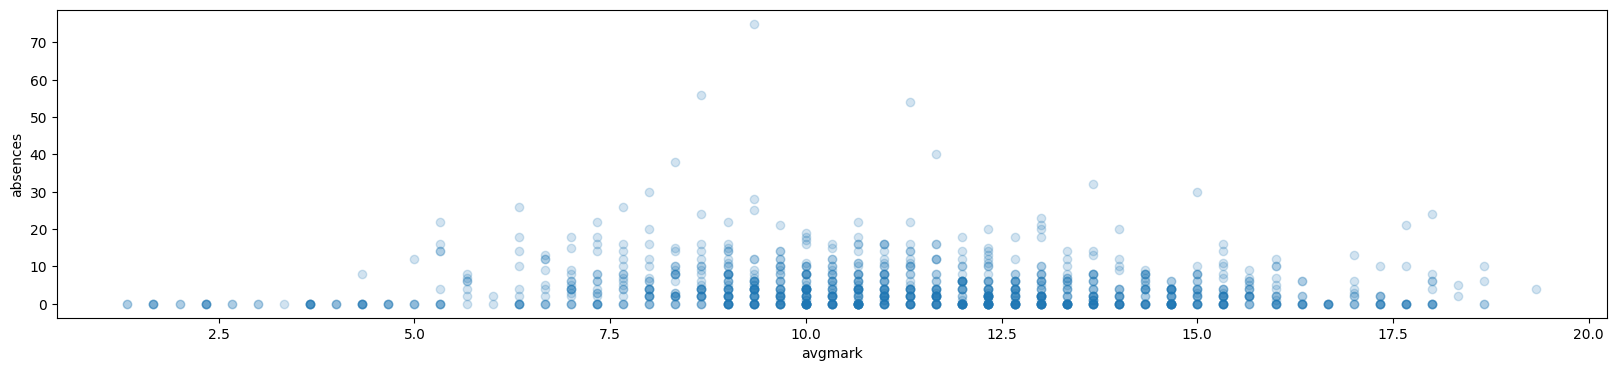

In [157]:
plt.rcParams['figure.figsize'] = [20, 4]
absences_dec = decode(data['absences'], 'absences')
plt.scatter(data['avgmark'], absences_dec,   alpha=0.2)
plt.ylabel('absences')
plt.xlabel('avgmark')
plt.show()